# Model Training 
This is the code is the training code for ML-based approach in intrusion detection. It was modified from notebook provided by "[**Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection**](https://arxiv.org/pdf/2409.03141)".

Please also cite:
L. Yang and A. Shami, “Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection,” in Proceedings of the Workshop on Autonomous Cybersecurity (AutonomousCyber ’24), 2024 ACM SIGSAC Conference on Computer and Communications Security (CCS’24), 2024, pp. 1–11. doi: 10.1145/3689933.3690833.

```
@INPROCEEDINGS{3690833,
  author={Yang, Li and Shami, Abdallah},
  title = {Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection},
  booktitle = {Proceedings of the Workshop on Autonomous Cybersecurity (AutonomousCyber '24), ACM Conference on Computer and Communications Security (CCS) 2024},
  year = {2024},
  address = {Salt Lake City, UT, USA},
  pages = {1-11},
  doi = {10.1145/3689933.3690833}
}
```

## Import libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
import time

In [4]:
CHECKPOINT_OUTPUT = "./models"

## Dataset 1: CICIDS2017
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  

Due to the large size of this dataset and the file size limit of GitHub, the sampled subset of CICIDS2017 is used. The subsets are in the "Data" folder.  PS: The results might be different from the paper due to the size difference of the dataset.

The Canadian Institute for Cybersecurity Intrusion Detection System 2017 (CICIDS2017) dataset has the most updated network threats. The CICIDS2017 dataset is close to real-world network data since it has a large amount of network traffic data, a variety of network features, various types of attacks, and highly imbalanced classes.


### Load data

In [4]:
# Read the dataset
df = pd.read_csv('../../datasets/output/train_final.csv', parse_dates=['Timestamp'])

In [5]:
df = df.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp', 'Old Index', 'Fwd TCP Retrans. Count', 'Bwd TCP Retrans. Count', 'Total TCP Retrans. Count', 'Total Connection Flow Time'], axis=1)

In [6]:
df['Label'].value_counts()

Label
Benign       484847
Portscan     127232
Slowloris      4565
Name: count, dtype: int64

In [7]:
df['Label'] = df['Label'].map({
    "Slowloris": "Slowloris",
    "Portscan": "Not Slowloris",
    "Benign": "Not Slowloris"
})

In [8]:
df['Label'].value_counts()

Label
Not Slowloris    612079
Slowloris          4565
Name: count, dtype: int64

### Data pre-processing

In [9]:
# Encode the dataset
labelencoder = LabelEncoder()
df['Label'] = labelencoder.fit_transform(df['Label'])

In [10]:
df['Label'].value_counts()

Label
0    612079
1      4565
Name: count, dtype: int64

In [11]:
labelencoder = LabelEncoder()
labelencoder.fit_transform(['Not Slowloris', 'Slowloris'])

array([0, 1])

In [12]:
df.isnull().any().any()

False

In [13]:
df.isna().any().any()

False

In [14]:
# Split the dataset into training and testing
X = df.drop(['Label'],axis=1) 
y = df['Label'].values.reshape(-1,1)
y=np.ravel(y)
X_train, X_val, y_train, y_val = train_test_split(X,y, train_size = 0.75, test_size = 0.25, random_state = 0, stratify = y)
# 0.75 & 0.25 means 60% train and 20% validation FROM WHOLE DATASET (counting test)

In [15]:
labelencoder.classes_

array(['Not Slowloris', 'Slowloris'], dtype='<U13')

## Data Balancing by Proposed TVAE-based Method

In [16]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)

In [17]:
y_train = pd.Series(y_train)
y_val = pd.Series(y_val)

In [18]:
from sdv.single_table import TVAESynthesizer
# Identify the average number of samples per class
average_samples = y_train.value_counts().mean()

# Identify minority classes with less than half the average number of samples
minority_classes = y_train.value_counts()
minority_classes = minority_classes[minority_classes < average_samples / 2].index.tolist()

# Prepare an empty DataFrame to collect synthetic data
synthetic_data = pd.DataFrame()

In [19]:
y_train.index = X_train.index

In [20]:
# Generating synthetic samples for each minority class using TVAE
for cls in minority_classes:
    cls_samples = X_train[y_train == cls]
    num_samples_needed = int(average_samples - len(cls_samples))
    
    # Initialize the TVAE model with detected metadata
    tvaegan = TVAESynthesizer(metadata=metadata, cuda=True, verbose=True)
    
    # Fit the TVAE model on the minority class samples
    tvaegan.fit(cls_samples.assign(Label=y_train[y_train == cls]))  # add Label temporarily for TVAE training
    
    # Generate synthetic instances to match the average class sample size
    new_samples = tvaegan.sample(num_samples_needed)
    
    # Append the new synthetic instances to the synthetic data list
    synthetic_data = pd.concat([synthetic_data, new_samples], ignore_index=True)

Loss: -457.167: 100%|██████████| 300/300 [01:04<00:00,  4.63it/s]


In [21]:
# Concatenate the original and synthetic data to form a balanced dataset
balanced_data = pd.concat([X_train.assign(Label=y_train), synthetic_data], ignore_index=True)

# Display the new distribution of labels in the balanced dataset
print(balanced_data['Label'].value_counts())

# Prepare the balanced dataset for model training
X_train_balanced = balanced_data.drop(['Label'], axis=1)
y_train_balanced = balanced_data['Label']

Label
0    459059
1    231241
Name: count, dtype: int64


In [22]:
X_val.reset_index().to_csv(f"{CHECKPOINT_OUTPUT}/X_val.csv", index=False)
X_train_balanced.to_csv(f"{CHECKPOINT_OUTPUT}/X_train_balanced.csv", index=False)
y_val.reset_index().to_csv(f"{CHECKPOINT_OUTPUT}/y_val.csv", index=False)
y_train_balanced.to_csv(f"{CHECKPOINT_OUTPUT}/y_train_balanced.csv", index=False)

In [8]:
X_val = pd.read_csv(f"{CHECKPOINT_OUTPUT}/X_val.csv", index_col=0)
X_train_balanced = pd.read_csv(f"{CHECKPOINT_OUTPUT}/X_train_balanced.csv")
y_val = pd.read_csv(f"{CHECKPOINT_OUTPUT}/y_val.csv", index_col=0)['0']
y_train_balanced = pd.read_csv(f"{CHECKPOINT_OUTPUT}/y_train_balanced.csv")['Label']

## Machine learning model training (for feature selection)

### Training six base learners (for comparison purposes): 
decision tree, random forest, extra trees, XGBoost, LightGBM, and CatBoost


#### DT

Training time:  25.910332202911377
Prediction time per sample:  0.00016733114461162457
Accuracy of DT: 0.9999610796504953
Precision of DT: 0.9982436835437918
Recall of DT: 0.9991105056237888
F1-score of DT: 0.9986767121819253
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



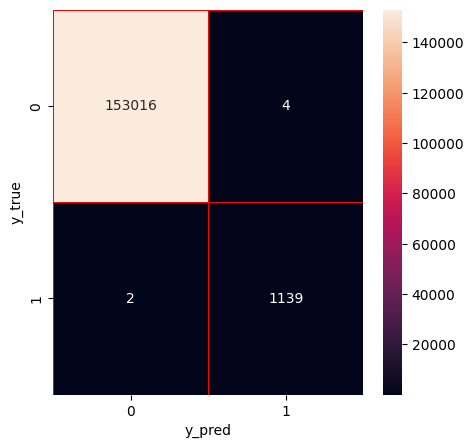

In [6]:
# %%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

# Decision tree training and prediction with 3-fold cross-validation
dt = DecisionTreeClassifier(random_state=0)

# calculate the training time
start = time.time()
dt.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val)*1000)

y_true = y_val

# Evaluation metrics
dt_score = dt.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

dt_f1_score = fscore

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### RF

Training time:  37.56062650680542
Prediction time:  0.000900743446278585 ms
Accuracy of RF: 0.9999805398252476
Precision of RF: 0.9995548684580273
Recall of RF: 0.9991203082639665
F1-score of RF: 0.9993374923829057
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



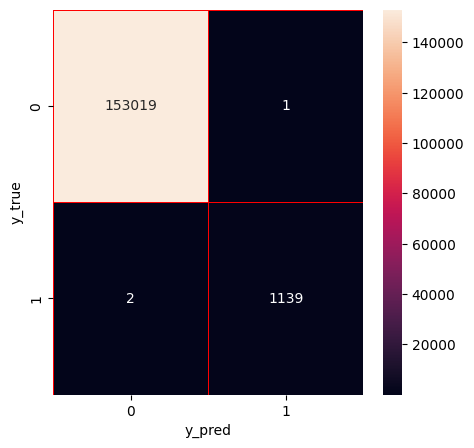

In [7]:
# %%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Random Forest training and prediction with 3-fold cross-validation
rf = RandomForestClassifier(random_state=0, n_jobs=8)

# calculate the training time
start = time.time()
rf.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_val)
end = time.time()
print('Prediction time: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_val

# Evaluation metrics
rf_score = rf.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

rf_f1_score = fscore

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


#### ET

Training time:  17.97193217277527
Prediction time:  0.0008862862432412318 ms
Accuracy of ET: 0.9999740531003302
Precision of ET: 0.9991170407172405
Recall of ET: 0.9991170407172405
F1-score of ET: 0.9991170407172405
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



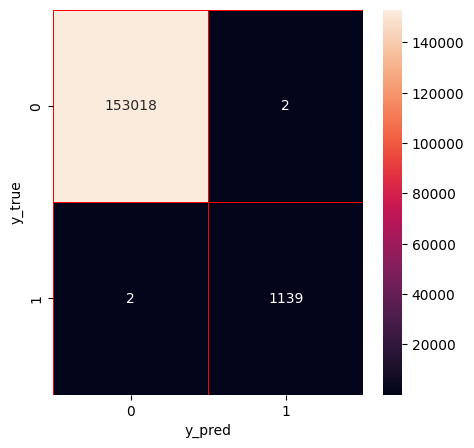

In [8]:
# %%time
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Extra Trees training and prediction with 3-fold cross-validation
et = ExtraTreesClassifier(random_state=0, n_jobs=8)

# calculate the training time
start = time.time()
et.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = et.predict(X_val)
end = time.time()
print('Prediction time: ', (end - start) / len(X_val) * 1000, 'ms')


y_true = y_val

# Evaluation metrics
et_score = et.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

et_f1_score = fscore

# Print results
print('Accuracy of ET: ' + str(et_score))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


#### XGBoost

Training time:  2.291407346725464
Prediction time per sample:  0.00021469750719453176
Accuracy of XGBoost: 0.9999805398252476
Precision of XGBoost: 0.9995548684580273
Recall of XGBoost: 0.9991203082639665
F1-score of XGBoost: 0.9993374923829057
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



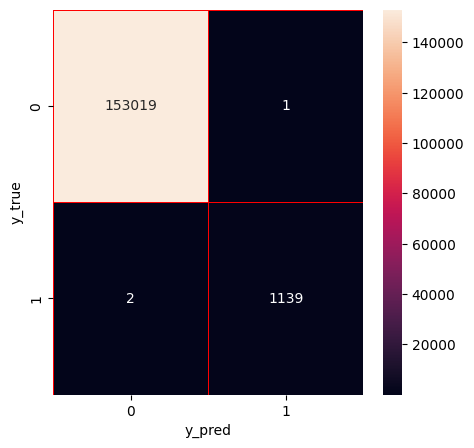

In [9]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# XGBoost training and prediction with 3-fold cross-validation
xg = xgb.XGBClassifier(random_state=0, n_jobs=8)

# calculate the training time
start = time.time()
xg.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)

y_true = y_val

# Evaluation metrics
xg_score = xg.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

xg_f1_score = fscore

# Print results
print('Accuracy of XGBoost: ' + str(xg_score))
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 231241, number of negative: 459059
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16265
[LightGBM] [Info] Number of data points in the train set: 690300, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334986 -> initscore=-0.685718
[LightGBM] [Info] Start training from score -0.685718
Training time:  2.6665592193603516
Prediction time per sample:  0.0005781875953711681
Accuracy of LightGBM: 0.9999805398252476
Precision of LightGBM: 0.9995548684580273
Recall of LightGBM: 0.9991203082639665
F1-score of LightGBM: 0.9993374923829057
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020


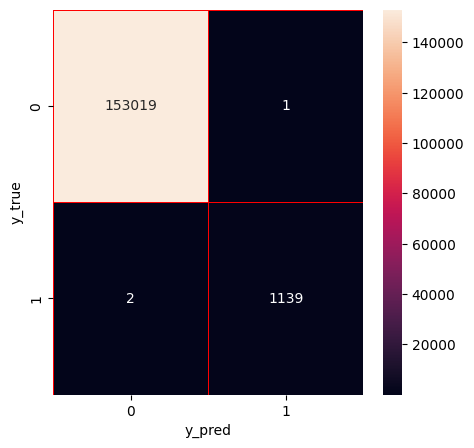

In [10]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# LightGBM training and prediction with 3-fold cross-validation
lgbm = lgb.LGBMClassifier(random_state=0, n_jobs=8)

# calculate the training time
start = time.time()
lgbm.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)

y_true = y_val

# Evaluation metrics
lgbm_score = lgbm.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

lgbm_f1_score = fscore

# Print results
print('Accuracy of LightGBM: ' + str(lgbm_score))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


#### Catboost

Training time:  38.80015468597412
Prediction time per sample:  0.00022236533054275569
Accuracy of CatBoost: 0.9999545929255778
Precision of CatBoost: 0.9982388838106468
Recall of CatBoost: 0.9986722935291349
F1-score of CatBoost: 0.9984554930278462
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



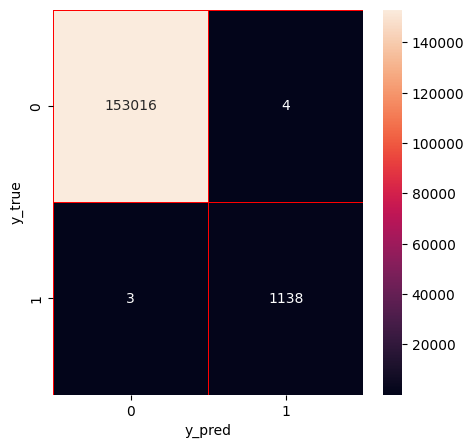

In [11]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# CatBoost training and prediction with 3-fold cross-validation
cat = CatBoostClassifier(random_state=0, verbose=False, thread_count=8)

# calculate the training time
start = time.time()
cat.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = cat.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)

y_true = y_val

# Evaluation metrics
cat_score = cat.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

cat_f1_score = fscore

# Print results
print('Accuracy of CatBoost: ' + str(cat_score))
print('Precision of CatBoost: ' + str(precision))
print('Recall of CatBoost: ' + str(recall))
print('F1-score of CatBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [5]:
MODEL_OUTPUT_PREFS = "./models/prefs"

In [16]:
import joblib

joblib.dump(dt, f"{MODEL_OUTPUT_PREFS}/dt.pkl")
joblib.dump(rf, f"{MODEL_OUTPUT_PREFS}/rf.pkl")
joblib.dump(et, f"{MODEL_OUTPUT_PREFS}/et.pkl")
joblib.dump(xg, f"{MODEL_OUTPUT_PREFS}/xg.pkl")
joblib.dump(lgbm, f"{MODEL_OUTPUT_PREFS}/lgbm.pkl")
joblib.dump(cat, f"{MODEL_OUTPUT_PREFS}/cat.pkl")

['./models/prefs/cat.pkl']

In [17]:
import gc
gc.collect()

10435

## Model selection

In [12]:
# Calculate the performance of each base model (e.g., accuracy)
base_model_performance = {
    'dt': dt_f1_score,
    'rf': rf_f1_score,
    'et': et_f1_score,
    'xg': xg_f1_score,
    'lgbm': lgbm_f1_score,
    'cat': cat_f1_score,
}

# Rank the base models based on their performance
ranked_models = sorted(base_model_performance, key=base_model_performance.get, reverse=True)

# Select the top-3 performing base models
top_3_models = ranked_models[:3]

In [13]:
top_3_models

['rf', 'xg', 'lgbm']

# Checkpoint

In [1]:
top_3_models = ['rf', 'xg', 'lgbm']

In [6]:
import joblib
dt = joblib.load(f"{MODEL_OUTPUT_PREFS}/dt.pkl")
rf = joblib.load(f"{MODEL_OUTPUT_PREFS}/rf.pkl")
et = joblib.load(f"{MODEL_OUTPUT_PREFS}/et.pkl")
xg = joblib.load(f"{MODEL_OUTPUT_PREFS}/xg.pkl")
lgbm = joblib.load(f"{MODEL_OUTPUT_PREFS}/lgbm.pkl")
cat = joblib.load(f"{MODEL_OUTPUT_PREFS}/cat.pkl")

## Model Ensemble

In [9]:
# record the results
dt_train=dt.predict(X_train_balanced)
dt_val=dt.predict(X_val)
dt_prob_train=dt.predict_proba(X_train_balanced)
dt_prob_val=dt.predict_proba(X_val)

rf_train=rf.predict(X_train_balanced)
rf_val=rf.predict(X_val)
rf_prob_train=rf.predict_proba(X_train_balanced)
rf_prob_val=rf.predict_proba(X_val)

et_train=et.predict(X_train_balanced)
et_val=et.predict(X_val)
et_prob_train=et.predict_proba(X_train_balanced)
et_prob_val=et.predict_proba(X_val)

xg_train=xg.predict(X_train_balanced)
xg_val=xg.predict(X_val)
xg_prob_train=xg.predict_proba(X_train_balanced)
xg_prob_val=xg.predict_proba(X_val)

lgbm_train=lgbm.predict(X_train_balanced)
lgbm_val=lgbm.predict(X_val)
lgbm_prob_train=lgbm.predict_proba(X_train_balanced)
lgbm_prob_val=lgbm.predict_proba(X_val)

cat_train=cat.predict(X_train_balanced)
cat_val=cat.predict(X_val)
cat_prob_train=cat.predict_proba(X_train_balanced)
cat_prob_val=cat.predict_proba(X_val)

In [10]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
lgbm_train=lgbm_train.reshape(-1, 1)
cat_train=cat_train.reshape(-1, 1)

dt_val=dt_val.reshape(-1, 1)
et_val=et_val.reshape(-1, 1)
rf_val=rf_val.reshape(-1, 1)
xg_val=xg_val.reshape(-1, 1)
lgbm_val=lgbm_val.reshape(-1, 1)
cat_val=cat_val.reshape(-1, 1)

[LightGBM] [Info] Number of positive: 231241, number of negative: 459059
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6
[LightGBM] [Info] Number of data points in the train set: 690300, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334986 -> initscore=-0.685718
[LightGBM] [Info] Start training from score -0.685718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

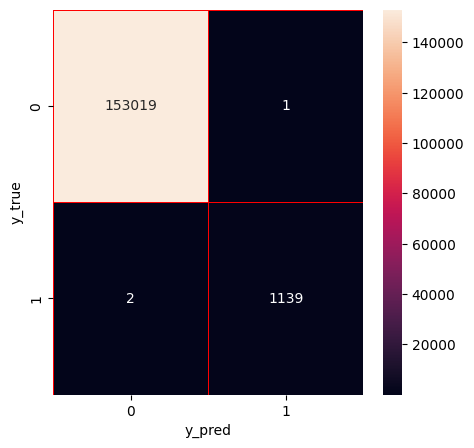

In [14]:
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensemble method 1: traditional stacking

# Get the predictions of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_val_predictions = [globals()[model.lower() + '_val'] for model in top_3_models]

# Stack the predictions of the top-3 models
x_train = np.concatenate(top_3_train_predictions, axis=1)
x_val = np.concatenate(top_3_val_predictions, axis=1)

# Train and evaluate the stacking model
# calcualte the traning time
start_time = time.time()
stk =  lgb.LGBMClassifier(random_state=0).fit(x_train, y_train_balanced)
end_time = time.time()
stk_time = end_time - start_time
print('Training time of Stacking: '+ str(stk_time))

# calcualte the testing time per sample in milliseconds
start_time = time.time()
y_predict=stk.predict(x_val)
end_time = time.time()
stk_time = (end_time - start_time)/len(x_val)*1000
print('Testing time of Stacking: '+ str(stk_time))

y_true=y_val

stk_accuracy=accuracy_score(y_true,y_predict)

precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='macro') 

print('Accuracy of Stacking: '+ str(stk_accuracy))
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [16]:
joblib.dump(stk, f"{MODEL_OUTPUT_PREFS}/stk1.pkl")

['./models/prefs/stk1.pkl']

[LightGBM] [Info] Number of positive: 231241, number of negative: 459059
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 690300, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334986 -> initscore=-0.685718
[LightGBM] [Info] Start training from score -0.685718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

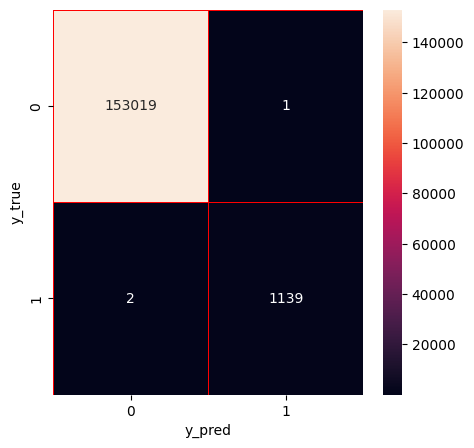

In [18]:
# Ensemble method 2: confidence-based stacking

# Get the prediction probabilities of the top-3 models
top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_val_proba = [globals()[model.lower() + '_prob_val'] for model in top_3_models]

# Stack the predictions and prediction probabilities of the top-3 models
x_train = np.concatenate(top_3_train_proba, axis=1)
x_val = np.concatenate(top_3_val_proba, axis=1)

# Train and evaluate the stacking model
# calcualte the traning time
start_time = time.time()
stk =  lgb.LGBMClassifier(random_state=0).fit(x_train, y_train_balanced)
end_time = time.time()
stk_time = end_time - start_time
print('Training time of Stacking: '+ str(stk_time))

# calcualte the testing time per sample in milliseconds
start_time = time.time()
y_predict=stk.predict(x_val)
end_time = time.time()
stk_time = (end_time - start_time)/len(x_val)*1000
print('Testing time of Stacking: '+ str(stk_time))

y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='macro')

print('Accuracy of Stacking: '+ str(stk_score))
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [20]:
joblib.dump(stk, f"{MODEL_OUTPUT_PREFS}/stk2.pkl")

['./models/prefs/stk2.pkl']

[LightGBM] [Info] Number of positive: 231241, number of negative: 459059
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 873
[LightGBM] [Info] Number of data points in the train set: 690300, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334986 -> initscore=-0.685718
[LightGBM] [Info] Start training from score -0.685718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

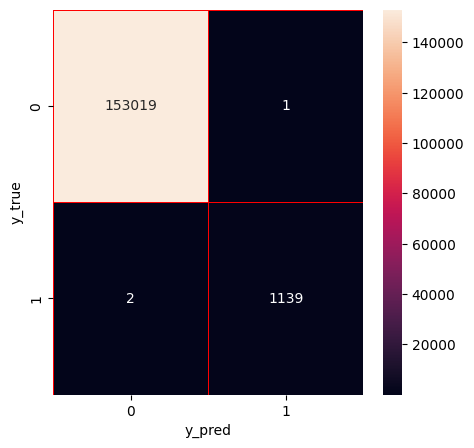

In [21]:
# Ensemble method 3: hybrid stacking

# Get the predictions and prediction probabilities of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_val_predictions = [globals()[model.lower() + '_val'] for model in top_3_models]

top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_val_proba = [globals()[model.lower() + '_prob_val'] for model in top_3_models]

# Combine the predictions and prediction probabilities of the top-3 models
x_train = np.concatenate(top_3_train_predictions + top_3_train_proba, axis=1)
x_val = np.concatenate(top_3_val_predictions + top_3_val_proba, axis=1)

# Train and evaluate the stacking model
# calcualte the traning time
start_time = time.time()
stk =  lgb.LGBMClassifier(random_state=0).fit(x_train, y_train_balanced)
end_time = time.time()
stk_time = end_time - start_time
print('Training time of Stacking: '+ str(stk_time))

# calcualte the testing time per sample in milliseconds
start_time = time.time()
y_predict=stk.predict(x_val)
end_time = time.time()
stk_time = (end_time - start_time)/len(x_val)*1000
print('Testing time of Stacking: '+ str(stk_time))

y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='macro') 

print('Accuracy of Stacking: '+ str(stk_score))
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [24]:
joblib.dump(stk, f"{MODEL_OUTPUT_PREFS}/stk3.pkl")

['./models/prefs/stk3.pkl']

## Automated Feature Selection

In [19]:
# Save the feature importance lists generated by base ML algorithms
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
xg_feature = xg.feature_importances_
lgbm_feature = lgbm.feature_importances_
cat_feature = cat.feature_importances_

In [20]:
lgbm_feature = lgbm_feature/sum(lgbm_feature)
cat_feature = cat_feature/sum(cat_feature)

In [21]:
# Get the feature importances of the top-3 models
top_3_importances = [globals()[model.lower() + '_feature'] for model in top_3_models]

# Calculate the average importance of each feature
avg_feature = np.mean(top_3_importances, axis=0)

feature=X_train_balanced.columns.values
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True))

f_list = sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True)


Features sorted by their score:
[(0.2501, 'Fwd IAT Min'), (0.066, 'Bwd IAT Mean'), (0.0456, 'Fwd Seg Size Min'), (0.042, 'Flow Packets/s'), (0.0293, 'Fwd Packets/s'), (0.0278, 'Total Length of Bwd Packet'), (0.027, 'Bwd Act Data Pkts'), (0.026, 'Bwd IAT Min'), (0.0226, 'Flow IAT Mean'), (0.0216, 'FIN Flag Count'), (0.0207, 'Bwd Init Win Bytes'), (0.019, 'Fwd Bulk Rate Avg'), (0.0188, 'Active Min'), (0.018, 'Fwd Packet Length Max'), (0.0169, 'Fwd Packet Length Min'), (0.0163, 'Bwd Packets/s'), (0.0161, 'Bwd Header Length'), (0.016, 'Bwd Packet Length Mean'), (0.0158, 'Subflow Bwd Bytes'), (0.0145, 'Flow Duration'), (0.0141, 'Flow IAT Min'), (0.0137, 'Total Bwd packets'), (0.0134, 'Fwd Segment Size Avg'), (0.0132, 'FWD Init Win Bytes'), (0.013, 'Packet Length Mean'), (0.0124, 'Down/Up Ratio'), (0.0119, 'ACK Flag Count'), (0.0115, 'Fwd IAT Total'), (0.0114, 'SYN Flag Count'), (0.0109, 'Bwd Packet Length Max'), (0.0092, 'Subflow Fwd Packets'), (0.0092, 'Fwd Bytes/Bulk Avg'), (0.0087, 'Flow

In [22]:
# Select the important features from top-importance to bottom-importance until the accumulated importance reaches 0.9 (out of 1)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])
    if Sum>=0.9:
        break        

In [23]:
print(fs)

['Fwd IAT Min', 'Bwd IAT Mean', 'Fwd Seg Size Min', 'Flow Packets/s', 'Fwd Packets/s', 'Total Length of Bwd Packet', 'Bwd Act Data Pkts', 'Bwd IAT Min', 'Flow IAT Mean', 'FIN Flag Count', 'Bwd Init Win Bytes', 'Fwd Bulk Rate Avg', 'Active Min', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Bwd Packets/s', 'Bwd Header Length', 'Bwd Packet Length Mean', 'Subflow Bwd Bytes', 'Flow Duration', 'Flow IAT Min', 'Total Bwd packets', 'Fwd Segment Size Avg', 'FWD Init Win Bytes', 'Packet Length Mean', 'Down/Up Ratio', 'ACK Flag Count', 'Fwd IAT Total', 'SYN Flag Count', 'Bwd Packet Length Max', 'Subflow Fwd Packets', 'Fwd Bytes/Bulk Avg', 'Flow IAT Max', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd Header Length']


In [24]:
fs = ['Fwd IAT Min', 'Bwd IAT Mean', 'Fwd Seg Size Min', 'Flow Packets/s', 'Fwd Packets/s', 'Total Length of Bwd Packet', 'Bwd Act Data Pkts', 'Bwd IAT Min', 'Flow IAT Mean', 'FIN Flag Count', 'Bwd Init Win Bytes', 'Fwd Bulk Rate Avg', 'Active Min', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Bwd Packets/s', 'Bwd Header Length', 'Bwd Packet Length Mean', 'Subflow Bwd Bytes', 'Flow Duration', 'Flow IAT Min', 'Total Bwd packets', 'Fwd Segment Size Avg', 'FWD Init Win Bytes', 'Packet Length Mean', 'Down/Up Ratio', 'ACK Flag Count', 'Fwd IAT Total', 'SYN Flag Count', 'Bwd Packet Length Max', 'Subflow Fwd Packets', 'Fwd Bytes/Bulk Avg', 'Flow IAT Max', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd Header Length']

In [25]:
X_train_fs = X_train_balanced[fs]
X_val_fs = X_val[fs]

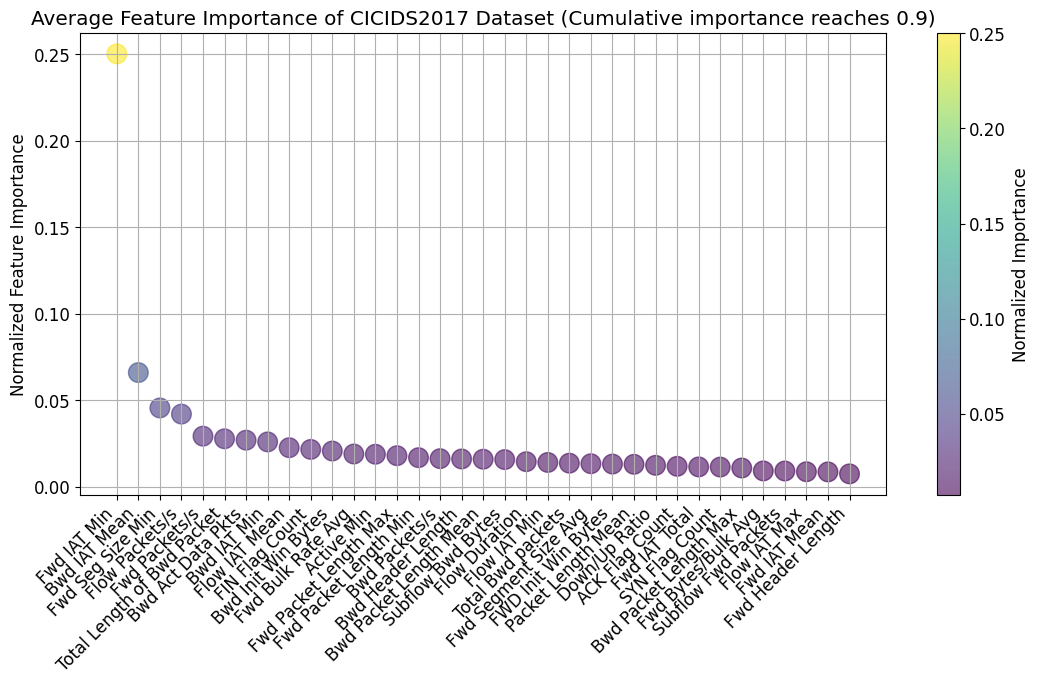

In [26]:
# Plot the feature importance of the top-3 models
plt.rcParams.update({'font.size': 12})

# Create a DataFrame for easier plotting
features = pd.DataFrame({
    'Feature': X_train_balanced.columns,
    'Importance': avg_feature
})

# Sort features by importance
features = features.sort_values(by='Importance', ascending=False)

# Calculate cumulative importance and filter features
features['Cumulative'] = features['Importance'].cumsum()
filtered_features = features[features['Cumulative'] <= 0.9]

# Plotting
plt.figure(figsize=(13, 6))
scatter = plt.scatter(x='Feature', y='Importance', s=200, c='Importance', cmap='viridis', alpha=0.6, data=filtered_features)
plt.colorbar(scatter, label='Normalized Importance')
plt.xticks(rotation=45, ha='right')
plt.title('Average Feature Importance of CICIDS2017 Dataset (Cumulative importance reaches 0.9)')
plt.ylabel('Normalized Feature Importance')
plt.grid(True)
plt.show()

In [27]:
num_features_original = len(X_train_balanced.columns)
num_features_selected = len(fs)

print(f"Features before selection: {num_features_original}")
print(f"Features after selection: {num_features_selected}")

Features before selection: 83
Features after selection: 36


# Testing

## Machine learning model training

### Training six base learners: 
decision tree, random forest, extra trees, XGBoost, LightGBM, and CatBoost


In [28]:
POST_FS_MODEL_OUTPUT = "./models/postfs"

### DT

Training time:  13.588293313980103
Prediction time per sample:  8.915584517515374e-05
Accuracy of DT: 0.999928646025908
Precision of DT: 0.9964997956433453
Recall of DT: 0.9986592233422312
F1-score of DT: 0.9975771309540895
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       0.99      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



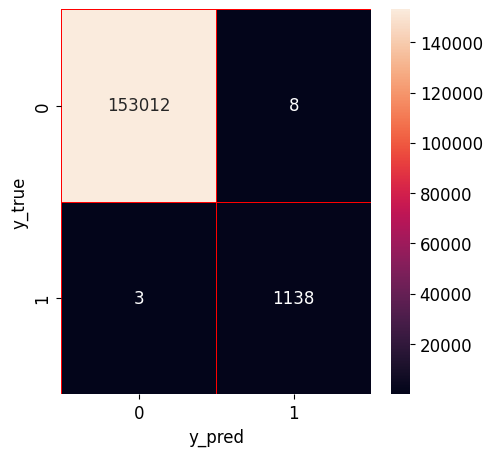

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

dt = DecisionTreeClassifier(random_state=0)

# calculate the training time
start = time.time()
dt.fit(X_train_fs, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_val_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val_fs)*1000)

y_true = y_val

# Evaluation metrics
dt_score = dt.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [30]:
joblib.dump(dt, f"{POST_FS_MODEL_OUTPUT}/dt_untuned.pkl")

['./models/postfs/dt_untuned.pkl']

100%|██████████| 20/20 [03:28<00:00, 10.43s/trial, best loss: -0.9991170407172405]
Decision Tree: Hyperopt estimated optimum {'criterion': 'entropy', 'max_depth': 37, 'min_samples_leaf': 3, 'min_samples_split': 8}
Accuracy of DT: 0.9999740531003302
Precision of DT: 0.9991170407172405
Recall of DT: 0.9991170407172405
F1-score of DT: 0.9991170407172405
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



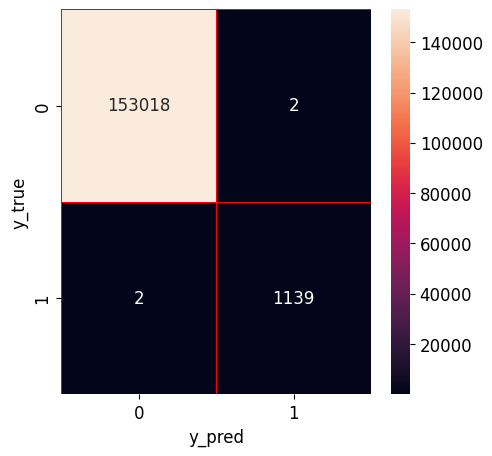

In [31]:
# Hyperparameter Optimization using BO-TPE

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, f1_score
from hyperopt import hp, fmin, tpe, STATUS_OK
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = DecisionTreeClassifier(random_state=0, **params)
    clf.fit(X_train_fs, y_train_balanced)
    y_pred = clf.predict(X_val_fs)
    score = f1_score(y_val, y_pred, average='macro')
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 11, 1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['max_depth'] = int(best['max_depth'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Decision Tree: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
dt = DecisionTreeClassifier(random_state=0, **best)
dt.fit(X_train_fs, y_train_balanced)

# Make predictions
y_predict = dt.predict(X_val_fs)
y_true = y_val

# Evaluation metrics
dt_score = dt.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


Accuracy of DT: 0.9999740531003302
Precision of DT: 0.9991170407172405
Recall of DT: 0.9991170407172405
F1-score of DT: 0.9991170407172405
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



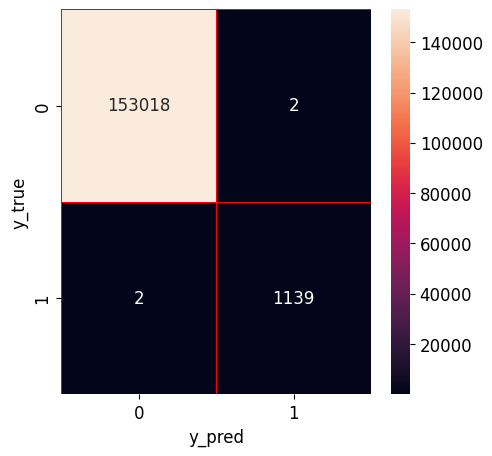

In [55]:
# Use the best parameters to train the model
dt = DecisionTreeClassifier(random_state=0, **{'criterion': 'entropy', 'max_depth': 37, 'min_samples_leaf': 3, 'min_samples_split': 8})
dt.fit(X_train_fs, y_train_balanced)

# Make predictions
y_predict = dt.predict(X_val_fs)
y_true = y_val

# Evaluation metrics
dt_score = dt.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

dt_f1_score = fscore

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [73]:
print(dt_f1_score)

0.9991170407172405


In [56]:
joblib.dump(dt, f"{POST_FS_MODEL_OUTPUT}/dt_tuned.pkl")

['./models/postfs/dt_tuned.pkl']

### RF

Training time:  27.10682964324951
Prediction time:  0.0007078307232073048 ms
Accuracy of RF: 0.9999545929255778
Precision of RF: 0.9978081500931086
Recall of RF: 0.9991072380770628
F1-score of RF: 0.9984568348091433
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



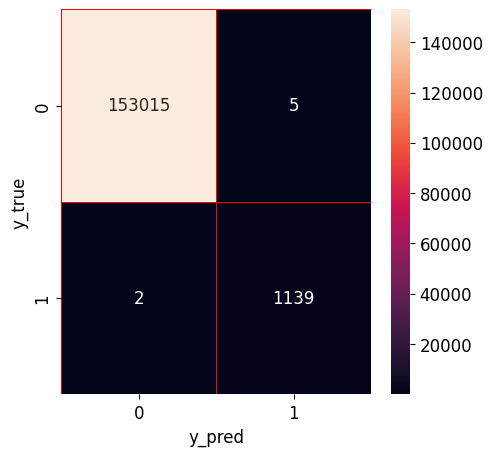

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

rf = RandomForestClassifier(random_state=0, n_jobs=8)

# calculate the training time
start = time.time()
rf.fit(X_train_fs, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_val_fs)
end = time.time()
print('Prediction time: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_val

# Evaluation metrics
rf_score = rf.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [34]:
joblib.dump(rf, f"{POST_FS_MODEL_OUTPUT}/rf_untuned.pkl")

['./models/postfs/rf_untuned.pkl']

100%|██████████| 20/20 [30:30<00:00, 91.52s/trial, best loss: -0.9993374923829057] 
Random Forest: Hyperopt estimated optimum {'criterion': 'gini', 'max_depth': 35, 'max_features': 19, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 98}
Accuracy of RF: 0.9999805398252476
Precision of RF: 0.9995548684580273
Recall of RF: 0.9991203082639665
F1-score of RF: 0.9993374923829057
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



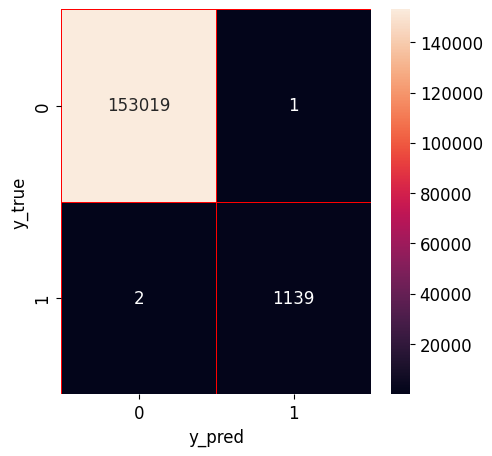

In [35]:
# Hyperparameter Optimization using BO-TPE

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = RandomForestClassifier(random_state=0, n_jobs=8, **params)
    clf.fit(X_train_fs, y_train_balanced)
    y_pred = clf.predict(X_val_fs)
    score = f1_score(y_val, y_pred, average='macro')
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 40, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['max_features'] = int(best['max_features'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Random Forest: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
rf = RandomForestClassifier(random_state=0, **best)
rf.fit(X_train_fs, y_train_balanced)

# Make predictions
y_predict = rf.predict(X_val_fs)
y_true = y_val

# Evaluation metrics
rf_score = rf.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Accuracy of RF: 0.9999805398252476
Precision of RF: 0.9995548684580273
Recall of RF: 0.9991203082639665
F1-score of RF: 0.9993374923829057
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



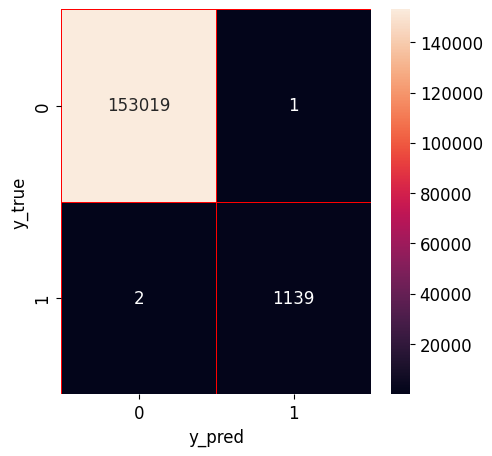

In [57]:
# Use the best parameters to train the model
rf = RandomForestClassifier(random_state=0, **{'criterion': 'gini', 'max_depth': 35, 'max_features': 19, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 98})
rf.fit(X_train_fs, y_train_balanced)

# Make predictions
y_predict = rf.predict(X_val_fs)
y_true = y_val

# Evaluation metrics
rf_score = rf.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

rf_f1_score = fscore

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [72]:
print(rf_f1_score)

0.9993374923829057


In [58]:
joblib.dump(rf, f"{POST_FS_MODEL_OUTPUT}/rf_tuned.pkl")

['./models/postfs/rf_tuned.pkl']

In [59]:
import gc
gc.collect()

41627

### ET

Training time:  13.52258014678955
Prediction time:  0.0007548862280869057 ms
Accuracy of ET: 0.9999481062006603
Precision of ET: 0.9973733773994694
Recall of ET: 0.9991039705303368
F1-score of ET: 0.9982371483649239
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       0.99      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



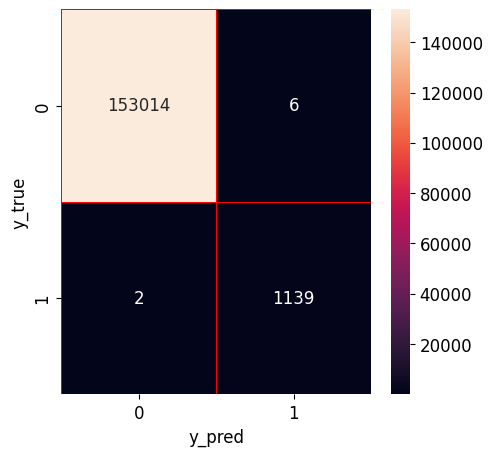

In [38]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

et = ExtraTreesClassifier(random_state=0, n_jobs=8)

# calculate the training time
start = time.time()
et.fit(X_train_fs, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = et.predict(X_val_fs)
end = time.time()
print('Prediction time: ', (end - start) / len(X_val_fs) * 1000, 'ms')

y_true = y_val

# Evaluation metrics
et_score = et.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of ET: ' + str(et_score))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [39]:
joblib.dump(et, f"{POST_FS_MODEL_OUTPUT}/et_untuned.pkl")

['./models/postfs/et_untuned.pkl']

100%|██████████| 20/20 [06:37<00:00, 19.86s/trial, best loss: -0.9982371483649239]
Extra Trees: Hyperopt estimated optimum {'criterion': 'gini', 'max_depth': 29, 'max_features': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 38}
Accuracy of ET: 0.9999481062006603
Precision of ET: 0.9973733773994694
Recall of ET: 0.9991039705303368
F1-score of ET: 0.9982371483649239
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       0.99      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



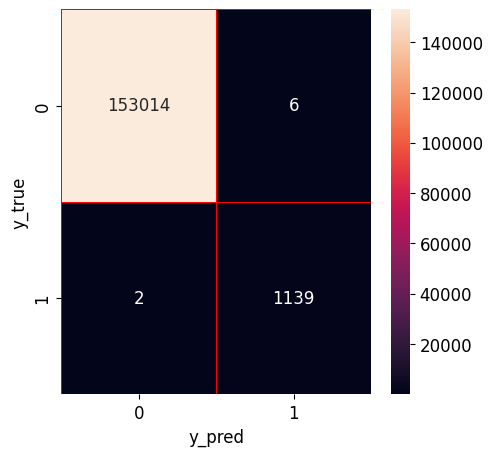

In [40]:
# Hyperparameter Optimization using BO-TPE

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = ExtraTreesClassifier(random_state=0, n_jobs=8, **params)
    clf.fit(X_train_fs, y_train_balanced)
    y_pred = clf.predict(X_val_fs)
    score = f1_score(y_val, y_pred, average='macro')
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    'max_features': hp.quniform('max_features', 1, 20, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 11, 1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['max_features'] = int(best['max_features'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Extra Trees: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
et = ExtraTreesClassifier(random_state=0, **best)
et.fit(X_train_fs, y_train_balanced)

# Make predictions
y_predict = et.predict(X_val_fs)
y_true = y_val

# Evaluation metrics
et_score = et.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of ET: ' + str(et_score))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


Accuracy of ET: 0.9999481062006603
Precision of ET: 0.9973733773994694
Recall of ET: 0.9991039705303368
F1-score of ET: 0.9982371483649239
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       0.99      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



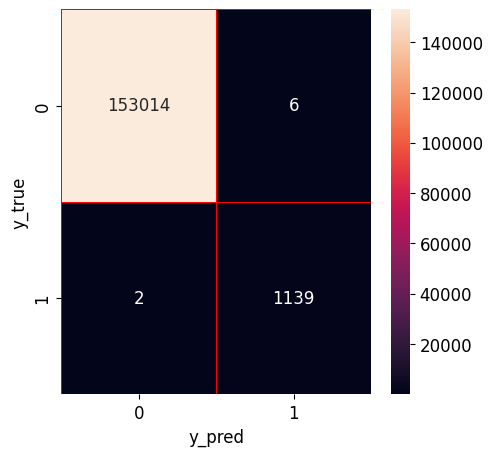

In [60]:
# Use the best parameters to train the model
et = ExtraTreesClassifier(random_state=0, **{'criterion': 'gini', 'max_depth': 29, 'max_features': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 38})
et.fit(X_train_fs, y_train_balanced)

# Make predictions
y_predict = et.predict(X_val_fs)
y_true = y_val

# Evaluation metrics
et_score = et.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

et_f1_score = fscore

# Print results
print('Accuracy of ET: ' + str(et_score))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [71]:
print(et_f1_score)

0.9982371483649239


In [61]:
joblib.dump(et, f"{POST_FS_MODEL_OUTPUT}/et_tuned.pkl")

['./models/postfs/et_tuned.pkl']

In [42]:
import gc
gc.collect()

10557

### XGBoost

Training time:  1.354074478149414
Prediction time per sample:  0.00015320645105790757
Accuracy of XGBoost: 0.9999545929255778
Precision of XGBoost: 0.9978081500931086
Recall of XGBoost: 0.9991072380770628
F1-score of XGBoost: 0.9984568348091433
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



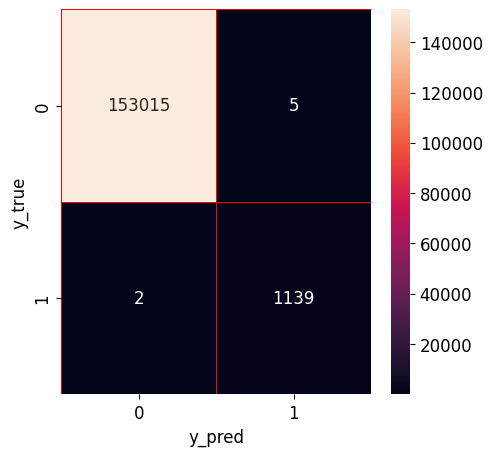

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

xg = xgb.XGBClassifier(random_state=0, n_jobs=8)

# calculate the training time
start = time.time()
xg.fit(X_train_fs, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_val_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val_fs) * 1000)

y_true = y_val

# Evaluation metrics
xg_score = xg.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of XGBoost: ' + str(xg_score))
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [44]:
joblib.dump(xg, f"{POST_FS_MODEL_OUTPUT}/xg_untuned.pkl")

['./models/postfs/xg_untuned.pkl']

100%|██████████| 20/20 [00:25<00:00,  1.26s/trial, best loss: -0.9993374923829057]
XGBoost: Hyperopt estimated optimum {'learning_rate': 0.41949444055541985, 'max_depth': 82, 'n_estimators': 85}
Accuracy of XGBoost: 0.9999805398252476
Precision of XGBoost: 0.9995548684580273
Recall of XGBoost: 0.9991203082639665
F1-score of XGBoost: 0.9993374923829057
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



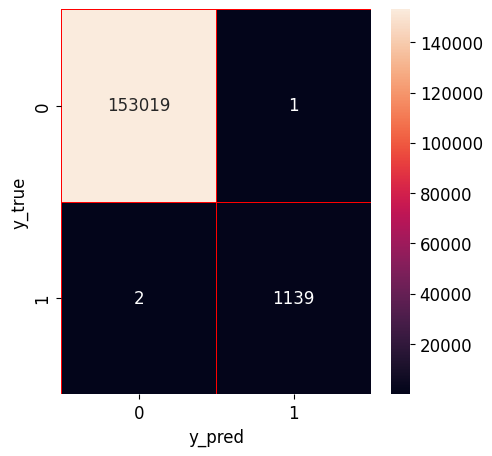

In [45]:
# Hyperparameter Optimization using BO-TPE

import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate']))
    }
    clf = xgb.XGBClassifier(eval_metric='logloss', random_state=0, n_jobs=8, **params)
    clf.fit(X_train_fs, y_train_balanced)
    y_pred = clf.predict(X_val_fs)
    score = f1_score(y_val, y_pred, average='macro')
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))

print("XGBoost: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
xg = xgb.XGBClassifier(eval_metric='logloss', random_state=0, **best)
xg.fit(X_train_fs, y_train_balanced)

# Make predictions
y_predict = xg.predict(X_val_fs)
y_true = y_val

# Evaluation metrics
xg_score = xg.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of XGBoost: ' + str(xg_score))
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


Accuracy of XGBoost: 0.9999805398252476
Precision of XGBoost: 0.9995548684580273
Recall of XGBoost: 0.9991203082639665
F1-score of XGBoost: 0.9993374923829057
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



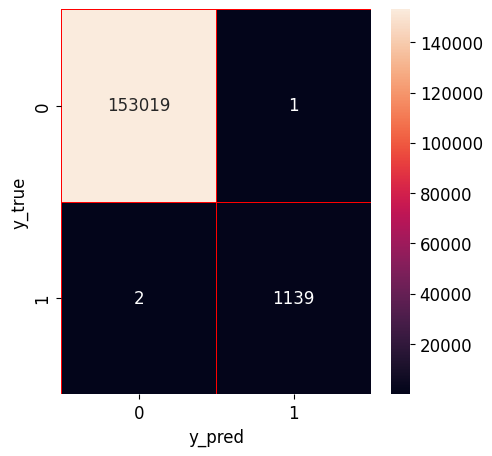

In [62]:
# Use the best parameters to train the model
xg = xgb.XGBClassifier(eval_metric='logloss', random_state=0, **{'learning_rate': 0.41949444055541985, 'max_depth': 82, 'n_estimators': 85})
xg.fit(X_train_fs, y_train_balanced)

# Make predictions
y_predict = xg.predict(X_val_fs)
y_true = y_val

# Evaluation metrics
xg_score = xg.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

xg_f1_score = fscore

# Print results
print('Accuracy of XGBoost: ' + str(xg_score))
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [70]:
print(xg_f1_score)

0.9993374923829057


In [63]:
joblib.dump(xg, f"{POST_FS_MODEL_OUTPUT}/xg_tuned.pkl")

['./models/postfs/xg_tuned.pkl']

### LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 231241, number of negative: 459059
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8272
[LightGBM] [Info] Number of data points in the train set: 690300, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334986 -> initscore=-0.685718
[LightGBM] [Info] Start training from score -0.685718
Training time:  1.8393597602844238
Prediction time per sample:  0.0006140924333809234
Accuracy of LightGBM: 0.9999805398252476
Precision of LightGBM: 0.9995548684580273
Recall of LightGBM: 0.9991203082639665
F1-score of LightGBM: 0.9993374923829057
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
 

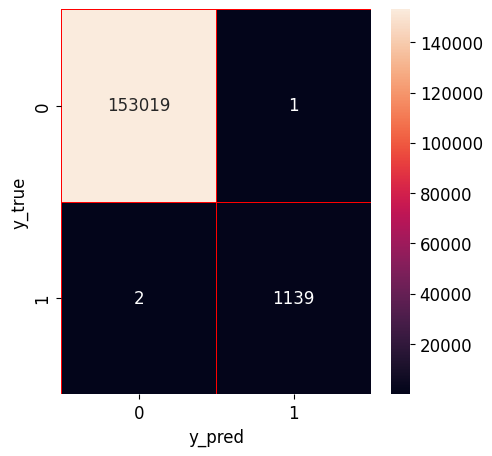

In [47]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# LightGBM training and prediction
lgbm = lgb.LGBMClassifier(random_state=0, n_jobs=8)

# calculate the training time
start = time.time()
lgbm.fit(X_train_fs, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_val_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val_fs) * 1000)

y_true = y_val

# Evaluation metrics
lgbm_score = lgbm.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of LightGBM: ' + str(lgbm_score))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [48]:
joblib.dump(lgbm, f"{POST_FS_MODEL_OUTPUT}/lgbm_untuned.pkl")

['./models/postfs/lgbm_untuned.pkl']

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 231241, number of negative: 459059
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8272                     
[LightGBM] [Info] Number of data points in the train set: 690300, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334986 -> initscore=-0.685718
[LightGBM] [Info] Start training from score -0.685718 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

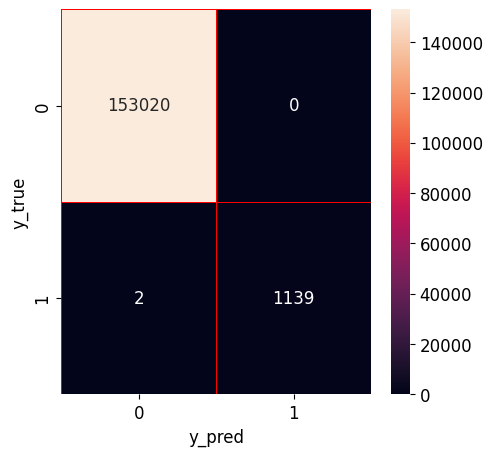

In [49]:
# Hyperparameter Optimization using BO-TPE

import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate'])),
        'num_leaves': int(params['num_leaves']),
        'min_child_samples': int(params['min_child_samples'])
    }
    clf = lgb.LGBMClassifier(random_state=0, n_jobs=8, **params)
    clf.fit(X_train_fs, y_train_balanced)
    y_pred = clf.predict(X_val_fs)
    score = f1_score(y_val, y_pred, average='macro')
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 3),
    'max_depth': hp.quniform('max_depth', 4, 100, 3),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
    'num_leaves': hp.quniform('num_leaves', 10, 50, 3),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 3)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))
best['num_leaves'] = int(best['num_leaves'])
best['min_child_samples'] = int(best['min_child_samples'])

print("LightGBM: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
lgbm = lgb.LGBMClassifier(random_state=0, **best)
lgbm.fit(X_train_fs, y_train_balanced)

# Make predictions
y_predict = lgbm.predict(X_val_fs)
y_true = y_val

# Evaluation metrics
lgbm_score = lgbm.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of LightGBM: ' + str(lgbm_score))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 231241, number of negative: 459059
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8272
[LightGBM] [Info] Number of data points in the train set: 690300, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334986 -> initscore=-0.685718
[LightGBM] [Info] Start training from score -0.685718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

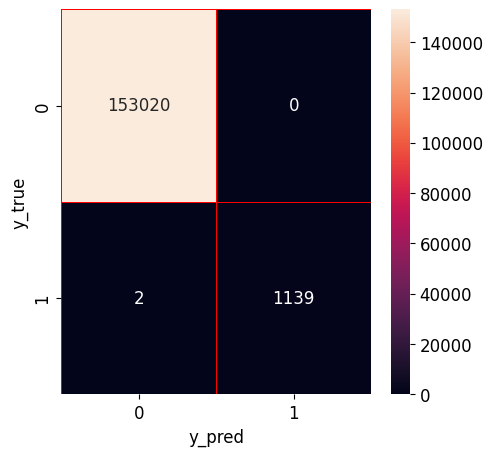

In [64]:
# Use the best parameters to train the model
lgbm = lgb.LGBMClassifier(random_state=0, **{'learning_rate': 1.0536247456706254, 'max_depth': 3, 'min_child_samples': 78, 'n_estimators': 39, 'num_leaves': 15})
lgbm.fit(X_train_fs, y_train_balanced)

# Make predictions
y_predict = lgbm.predict(X_val_fs)
y_true = y_val

# Evaluation metrics
lgbm_score = lgbm.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

lgbm_f1_score = fscore

# Print results
print('Accuracy of LightGBM: ' + str(lgbm_score))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [69]:
print(lgbm_f1_score)

0.9995581359833996


In [65]:
joblib.dump(lgbm, f"{POST_FS_MODEL_OUTPUT}/lgbm_tuned.pkl")

['./models/postfs/lgbm_tuned.pkl']

### CatBoost

Training time:  28.83508276939392
Prediction time per sample:  0.00015715480785661988
Accuracy of CatBoost: 0.9999481062006603
Precision of CatBoost: 0.9978029706350229
Recall of CatBoost: 0.9986690259824089
F1-score of CatBoost: 0.9982356162425671
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



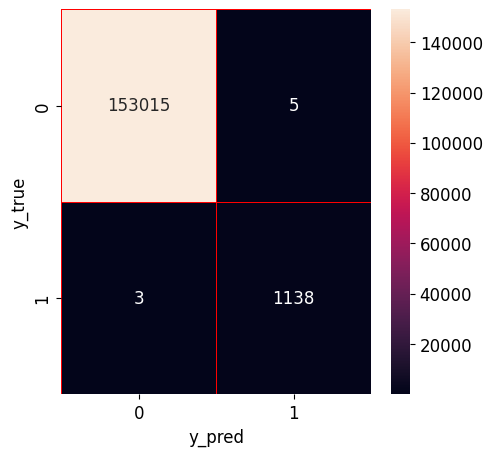

In [51]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# CatBoost training and prediction
cat = CatBoostClassifier(random_state=0, thread_count=8, verbose=False)

# calculate the training time
start = time.time()
cat.fit(X_train_fs, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = cat.predict(X_val_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val_fs) * 1000)

# Evaluation metrics
cat_score = cat.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of CatBoost: ' + str(cat_score))
print('Precision of CatBoost: ' + str(precision))
print('Recall of CatBoost: ' + str(recall))
print('F1-score of CatBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [52]:
joblib.dump(cat, f"{POST_FS_MODEL_OUTPUT}/cat_untuned.pkl")

['./models/postfs/cat_untuned.pkl']

100%|██████████| 20/20 [08:57<00:00, 26.89s/trial, best loss: -0.9986767121819253]
CatBoost: Hyperopt estimated optimum {'depth': 10, 'iterations': 900, 'learning_rate': 0.22169250403929858}
Accuracy of CatBoost: 0.9999610796504953
Precision of CatBoost: 0.9982436835437918
Recall of CatBoost: 0.9991105056237888
F1-score of CatBoost: 0.9986767121819253
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



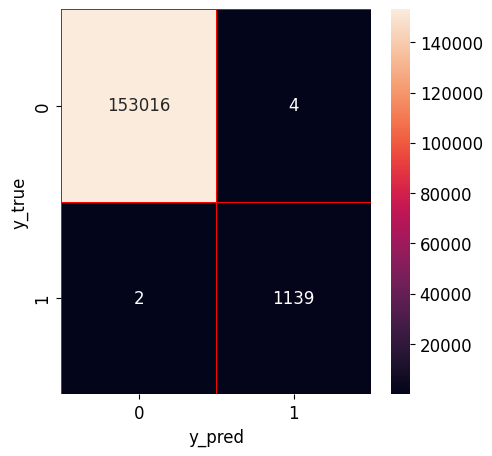

In [53]:
# Hyperparameter Optimization using BO-TPE

import catboost as cb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'depth': int(params['depth']),
        'learning_rate': params['learning_rate'],
        'iterations': int(params['iterations'])
    }
    clf = cb.CatBoostClassifier(random_state=0, verbose=False, thread_count=8, **params)
    clf.fit(X_train_fs, y_train_balanced)
    y_pred = clf.predict(X_val_fs)
    score = f1_score(y_val, y_pred, average='macro')
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'depth': hp.quniform('depth', 2, 12, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'iterations': hp.quniform('iterations', 100, 1000, 100)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['depth'] = int(best['depth'])
best['learning_rate'] = best['learning_rate']
best['iterations'] = int(best['iterations'])

print("CatBoost: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
cat = cb.CatBoostClassifier(random_state=0, verbose=False, **best)
cat.fit(X_train_fs, y_train_balanced)

# Make predictions
y_predict = cat.predict(X_val_fs)
y_true = y_val

# Evaluation metrics
cat_score = cat.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of CatBoost: ' + str(cat_score))
print('Precision of CatBoost: ' + str(precision))
print('Recall of CatBoost: ' + str(recall))
print('F1-score of CatBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


Accuracy of CatBoost: 0.9999610796504953
Precision of CatBoost: 0.9982436835437918
Recall of CatBoost: 0.9991105056237888
F1-score of CatBoost: 0.9986767121819253
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153020
           1       1.00      1.00      1.00      1141

    accuracy                           1.00    154161
   macro avg       1.00      1.00      1.00    154161
weighted avg       1.00      1.00      1.00    154161



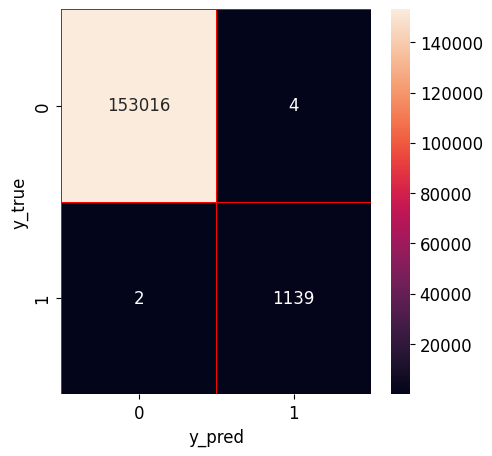

In [66]:
# Use the best parameters to train the model
cat = cb.CatBoostClassifier(random_state=0, verbose=False, **{'depth': 10, 'iterations': 900, 'learning_rate': 0.22169250403929858})
cat.fit(X_train_fs, y_train_balanced)

# Make predictions
y_predict = cat.predict(X_val_fs)
y_true = y_val

# Evaluation metrics
cat_score = cat.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

cat_f1_score = fscore

# Print results
print('Accuracy of CatBoost: ' + str(cat_score))
print('Precision of CatBoost: ' + str(precision))
print('Recall of CatBoost: ' + str(recall))
print('F1-score of CatBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [68]:
print(cat_f1_score)

0.9986767121819253


In [67]:
joblib.dump(cat, f"{POST_FS_MODEL_OUTPUT}/cat_tuned.pkl")

['./models/postfs/cat_tuned.pkl']

In [74]:
# record the results
dt_train=dt.predict(X_train_fs)
dt_val=dt.predict(X_val_fs)
dt_prob_train=dt.predict_proba(X_train_fs)
dt_prob_val=dt.predict_proba(X_val_fs)

rf_train=rf.predict(X_train_fs)
rf_val=rf.predict(X_val_fs)
rf_prob_train=rf.predict_proba(X_train_fs)
rf_prob_val=rf.predict_proba(X_val_fs)

et_train=et.predict(X_train_fs)
et_val=et.predict(X_val_fs)
et_prob_train=et.predict_proba(X_train_fs)
et_prob_val=et.predict_proba(X_val_fs)

xg_train=xg.predict(X_train_fs)
xg_val=xg.predict(X_val_fs)
xg_prob_train=xg.predict_proba(X_train_fs)
xg_prob_val=xg.predict_proba(X_val_fs)

lgbm_train=lgbm.predict(X_train_fs)
lgbm_val=lgbm.predict(X_val_fs)
lgbm_prob_train=lgbm.predict_proba(X_train_fs)
lgbm_prob_val=lgbm.predict_proba(X_val_fs)

cat_train=cat.predict(X_train_fs)
cat_val=cat.predict(X_val_fs)
cat_prob_train=cat.predict_proba(X_train_fs)
cat_prob_val=cat.predict_proba(X_val_fs)

## Model selection

In [75]:
# Calculate the performance of each base model (e.g., accuracy)
base_model_performance = {
    'dt': dt_f1_score,
    'rf': rf_f1_score,
    'et': et_f1_score,
    'xg': xg_f1_score,
    'lgbm': lgbm_f1_score,
    'cat': cat_f1_score,

}

# Rank the base models based on their performance
ranked_models = sorted(base_model_performance, key=base_model_performance.get, reverse=True)

# Select the top-3 performing base models
top_3_models = ranked_models[:3]

In [76]:
top_3_models

['lgbm', 'rf', 'xg']

In [77]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
lgbm_train=lgbm_train.reshape(-1, 1)
cat_train=cat_train.reshape(-1, 1)

dt_val=dt_val.reshape(-1, 1)
et_val=et_val.reshape(-1, 1)
rf_val=rf_val.reshape(-1, 1)
xg_val=xg_val.reshape(-1, 1)
lgbm_val=lgbm_val.reshape(-1, 1)
cat_val=cat_val.reshape(-1, 1)

[LightGBM] [Info] Number of positive: 231241, number of negative: 459059
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6
[LightGBM] [Info] Number of data points in the train set: 690300, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334986 -> initscore=-0.685718
[LightGBM] [Info] Start training from score -0.685718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

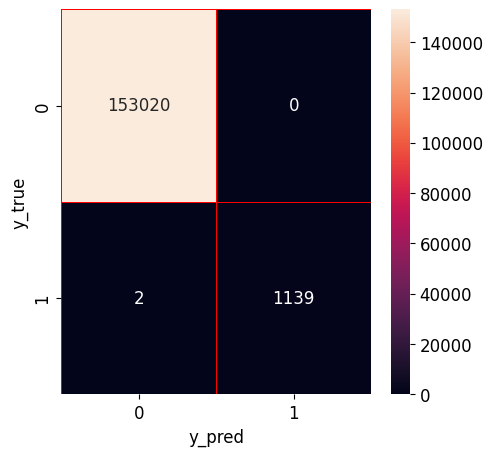

In [96]:
# Ensemble method 1: traditional stacking

# Get the predictions of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_val_predictions = [globals()[model.lower() + '_val'] for model in top_3_models]

# Stack the predictions of the top-3 models
x_train_balanced = np.concatenate(top_3_train_predictions, axis=1)
x_val = np.concatenate(top_3_val_predictions, axis=1)

# Train and evaluate the stacking model
stk1 = lgb.LGBMClassifier(random_state=0).fit(x_train_balanced, y_train_balanced)

y_predict=stk1.predict(x_val)

y_true=y_val

stk1_accuracy=accuracy_score(y_true,y_predict)

precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='macro') 

stk1_f1_score = fscore

print('Accuracy of Stacking: '+ str(stk1_accuracy))
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [97]:
joblib.dump(stk1, f"{POST_FS_MODEL_OUTPUT}/stk1.pkl")

['./models/postfs/stk1.pkl']

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

[LightGBM] [Info] Number of positive: 231241, number of negative: 459059
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6                        
[LightGBM] [Info] Number of data points in the train set: 690300, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334986 -> initscore=-0.685718
[LightGBM] [Info] Start training from score -0.685718 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

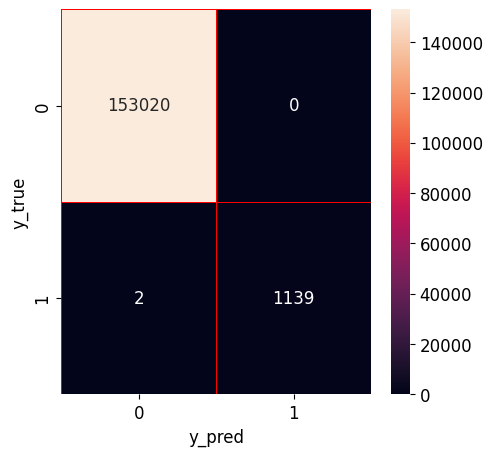

In [98]:
# Hyperparameter Optimization using BO-TPE

import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate'])),
        'num_leaves': int(params['num_leaves']),
        'min_child_samples': int(params['min_child_samples'])
    }
    clf = lgb.LGBMClassifier(random_state=0, n_jobs=8, **params)
    clf.fit(x_train_balanced, y_train_balanced)
    y_pred = clf.predict(x_val)
    score = f1_score(y_val, y_pred, average='macro')
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 3),
    'max_depth': hp.quniform('max_depth', 4, 100, 3),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
    'num_leaves': hp.quniform('num_leaves', 10, 50, 3),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 3)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))
best['num_leaves'] = int(best['num_leaves'])
best['min_child_samples'] = int(best['min_child_samples'])

print("LightGBM: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
stk1 = lgb.LGBMClassifier(random_state=0, **best)
stk1.fit(x_train_balanced, y_train_balanced)

# Make predictions
y_predict = stk1.predict(x_val)
y_true = y_val

# Evaluation metrics
stk1_accuracy = stk1.score(x_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

stk1_f1_score = fscore

# Print results
print('Accuracy of LightGBM: ' + str(stk1_accuracy))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [99]:
joblib.dump(stk1, f"{POST_FS_MODEL_OUTPUT}/stk1_tuned.pkl")

['./models/postfs/stk1_tuned.pkl']

[LightGBM] [Info] Number of positive: 231241, number of negative: 459059
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1119
[LightGBM] [Info] Number of data points in the train set: 690300, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334986 -> initscore=-0.685718
[LightGBM] [Info] Start training from score -0.685718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

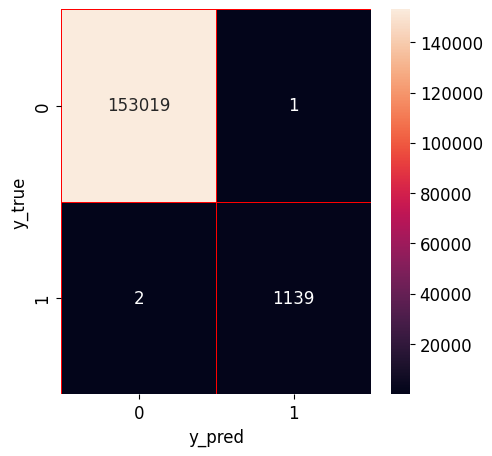

In [101]:
# Ensemble method 2: confidence-based stacking

# Get the prediction probabilities of the top-3 models
top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_val_proba = [globals()[model.lower() + '_prob_val'] for model in top_3_models]

# Stack the predictions and prediction probabilities of the top-3 models
x_train_balanced = np.concatenate(top_3_train_proba, axis=1)
x_val = np.concatenate(top_3_val_proba, axis=1)

# Train and evaluate the stacking model
stk2 = lgb.LGBMClassifier().fit(x_train_balanced, y_train_balanced)

y_predict=stk2.predict(x_val)

y_true=y_val

stk2_accuracy=accuracy_score(y_true,y_predict)

precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='macro')

stk2_f1_score = fscore

print('Accuracy of Stacking: '+ str(stk2_accuracy))
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [102]:
joblib.dump(stk2, f"{POST_FS_MODEL_OUTPUT}/stk2.pkl")

['./models/postfs/stk2.pkl']

[LightGBM] [Info] Number of positive: 231241, number of negative: 459059
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1126                     
[LightGBM] [Info] Number of data points in the train set: 690300, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334986 -> initscore=-0.685718
[LightGBM] [Info] Start training from score -0.685718 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

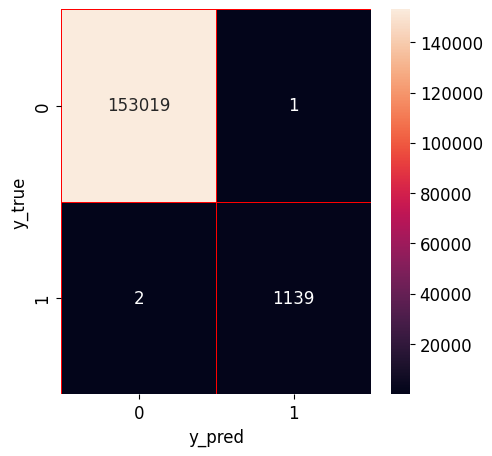

In [105]:
# Hyperparameter Optimization using BO-TPE

import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate'])),
        'num_leaves': int(params['num_leaves']),
        'min_child_samples': int(params['min_child_samples'])
    }
    clf = lgb.LGBMClassifier(random_state=0, n_jobs=8, **params)
    clf.fit(x_train_balanced, y_train_balanced)
    y_pred = clf.predict(x_val)
    score = f1_score(y_val, y_pred, average='macro')
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 3),
    'max_depth': hp.quniform('max_depth', 4, 100, 3),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
    'num_leaves': hp.quniform('num_leaves', 10, 50, 3),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 3)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))
best['num_leaves'] = int(best['num_leaves'])
best['min_child_samples'] = int(best['min_child_samples'])

print("LightGBM: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
stk2 = lgb.LGBMClassifier(random_state=0, **best)
stk2.fit(x_train_balanced, y_train_balanced)

# Make predictions
y_predict = stk2.predict(x_val)
y_true = y_val

# Evaluation metrics
stk2_accuracy = stk2.score(x_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

stk2_f1_score = fscore

# Print results
print('Accuracy of LightGBM: ' + str(stk2_accuracy))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [106]:
joblib.dump(stk2, f"{POST_FS_MODEL_OUTPUT}/stk2_tuned.pkl")

['./models/postfs/stk2_tuned.pkl']

In [108]:
x_train_balanced[0]

array([1.00000000e+00, 7.95570118e-12, 1.00000000e+00, 0.00000000e+00,
       9.99999821e-01, 1.60774349e-07])

[LightGBM] [Info] Number of positive: 231241, number of negative: 459059
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1125
[LightGBM] [Info] Number of data points in the train set: 690300, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334986 -> initscore=-0.685718
[LightGBM] [Info] Start training from score -0.685718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

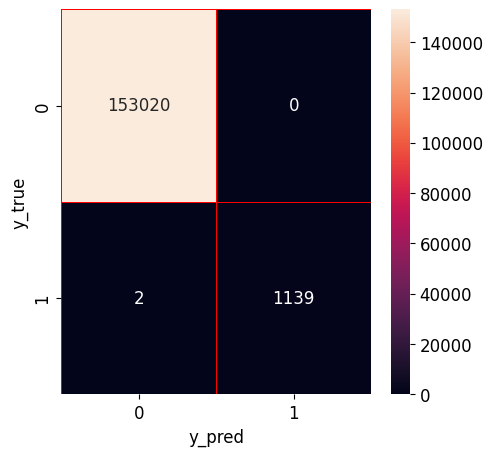

In [110]:
# Ensemble method 3: hybrid stacking
# Get the predictions and prediction probabilities of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_val_predictions = [globals()[model.lower() + '_val'] for model in top_3_models]

top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_val_proba = [globals()[model.lower() + '_prob_val'] for model in top_3_models]

# Combine the predictions and prediction probabilities of the top-3 models
x_train_balanced = np.concatenate(top_3_train_predictions + top_3_train_proba, axis=1)
x_val = np.concatenate(top_3_val_predictions + top_3_val_proba, axis=1)

# Train and evaluate the stacking model
stk3 = lgb.LGBMClassifier().fit(x_train_balanced, y_train_balanced)

y_predict=stk3.predict(x_val)

y_true=y_val

stk3_score=accuracy_score(y_true,y_predict)

precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='macro')

stk3_f1_score = fscore

print('Accuracy of Stacking: '+ str(stk3_score))
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [111]:
joblib.dump(stk3, f"{POST_FS_MODEL_OUTPUT}/stk3.pkl")

['./models/postfs/stk3.pkl']

[LightGBM] [Info] Number of positive: 231241, number of negative: 459059
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1132                     
[LightGBM] [Info] Number of data points in the train set: 690300, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334986 -> initscore=-0.685718
[LightGBM] [Info] Start training from score -0.685718 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

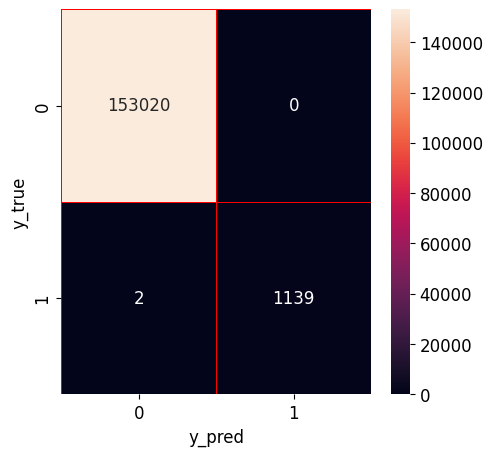

In [114]:
# Hyperparameter Optimization using BO-TPE

import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate'])),
        'num_leaves': int(params['num_leaves']),
        'min_child_samples': int(params['min_child_samples'])
    }
    clf = lgb.LGBMClassifier(random_state=0, n_jobs=8, **params)
    clf.fit(x_train_balanced, y_train_balanced)
    y_pred = clf.predict(x_val)
    score = f1_score(y_val, y_pred, average='macro')
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 3),
    'max_depth': hp.quniform('max_depth', 4, 100, 3),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
    'num_leaves': hp.quniform('num_leaves', 10, 50, 3),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 3)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))
best['num_leaves'] = int(best['num_leaves'])
best['min_child_samples'] = int(best['min_child_samples'])

print("LightGBM: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
stk3 = lgb.LGBMClassifier(random_state=0, **best)
stk3.fit(x_train_balanced, y_train_balanced)

# Make predictions
y_predict = stk3.predict(x_val)
y_true = y_val

# Evaluation metrics
stk3_accuracy = stk3.score(x_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

stk3_f1_score = fscore

# Print results
print('Accuracy of LightGBM: ' + str(stk3_accuracy))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [115]:
joblib.dump(stk3, f"{POST_FS_MODEL_OUTPUT}/stk3_tuned.pkl")

['./models/postfs/stk3_tuned.pkl']